## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers import Input, Activation
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from tensorflow.keras.utils import plot_model
import cv2
import pickle
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
np.random.seed(0)


##  Paths and Parameters

In [3]:
path = r'D:\Study_3\GTSRB_new'
labelFile = r'D:\Study_3\GTSRB_new\signnames.csv'

## Importing Images

In [4]:
os.chdir(path)

In [5]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

In [6]:
print(cur_path)

D:\Study_3\GTSRB_new


In [7]:
os.listdir(cur_path)

['acc.svg',
 'Accuracy.svg',
 'acc_new.svg',
 'combined_network.PNG',
 'inception+mlenet_module.png',
 'inception_module.jpg',
 'inception_module.png',
 'inception_test.PNG',
 'Loss.svg',
 'loss_1.svg',
 'loss_new.svg',
 'mean_image_gray.pickle',
 'mean_image_RGB.pickle',
 'model_inception.txt',
 'model_lenet_modified.txt',
 'model_trained.p',
 'model_trained_new.p',
 'naive_inception_module.png',
 'new_combined.png',
 'new_images',
 'signnames.csv',
 'test.p',
 'train.p',
 'training',
 'valid.p']

## Load files

In [8]:
with open(cur_path + '/' + 'train.p', 'rb') as f:
    train_data = pickle.load(f)
with open(cur_path + '/' + 'valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open(cur_path + '/' + 'test.p', 'rb') as f:
    test_data = pickle.load(f)
    
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


## Checking if No of images is equal to no of labels for wach data set...

In [10]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32*32*3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32*32*3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32*32*3"

## Save labels and data for future use 

In [11]:
# os.mkdir('training')
# np.save('./training/train_data', train_data)
# np.save('./training/val_data', val_data)
# np.save('./training/test_data', test_data)

## Read csv file

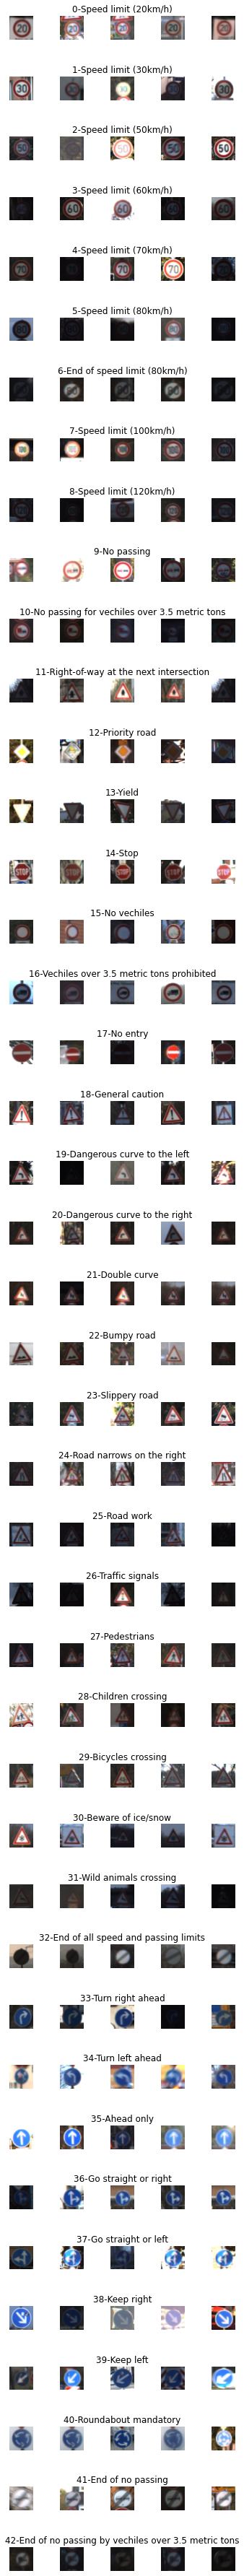

In [12]:
data_csv = pd.read_csv('signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data_csv.iterrows():
        x_selected = X_train[y_train==j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i==2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


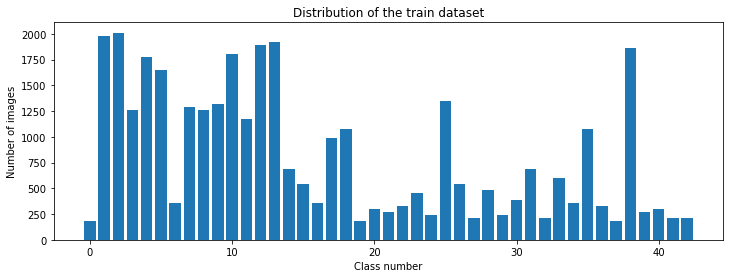

In [13]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

## Image Preprocessing

(32, 32, 3)
31


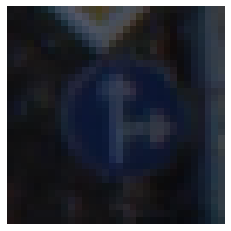

In [11]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[500].shape)
print(y_train[500])

In [14]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


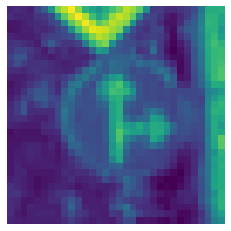

In [15]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


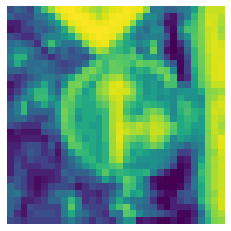

In [16]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [20]:
# Mean Image RGB...
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
dictionary = {'mean_image_RGB': mean_image}

# with open('mean_image_RGB' + '.pickle', 'wb') as f_mean_image:
#     pickle.dump(dictionary, f_mean_image)

(32, 32, 3)


(32, 32, 3)


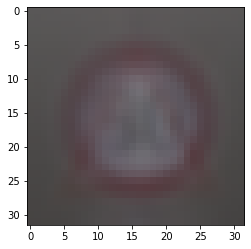

In [21]:
# Load mean_image file...
with open(r'D:\Study_3\GTSRB_new\mean_image_RGB.pickle', 'rb') as f:
    mean = pickle.load(f)
    
print(mean['mean_image_RGB'].shape)
plt.imshow(mean['mean_image_RGB'].astype('uint8'))

In [17]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [23]:
# save Mean Image Gray... (for mean image substraction)
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
dictionary = {'mean_image_gray': mean_image}

# with open('mean_image_gray' + '.pickle', 'wb') as f_mean_image:
#     pickle.dump(dictionary, f_mean_image)

(32, 32)


(32, 32)


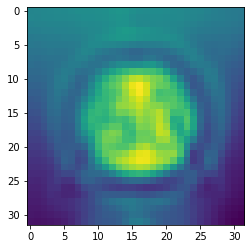

In [24]:
# Load mean_image file...
with open(r'D:\Study_3\GTSRB_new\mean_image_gray.pickle', 'rb') as f:
    mean = pickle.load(f)
    
print(mean['mean_image_gray'].shape)
plt.imshow(mean['mean_image_gray'].reshape(32,32,1))

(34799, 32, 32)


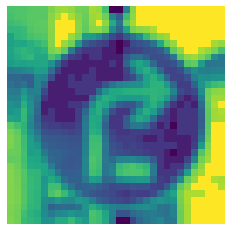

In [25]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [26]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

## Image Augmentation

In [27]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range= 0.1,
                             zoom_range= 0.2,
                             shear_range= 0.1,
                             rotation_range=10)

datagen.fit(X_train)

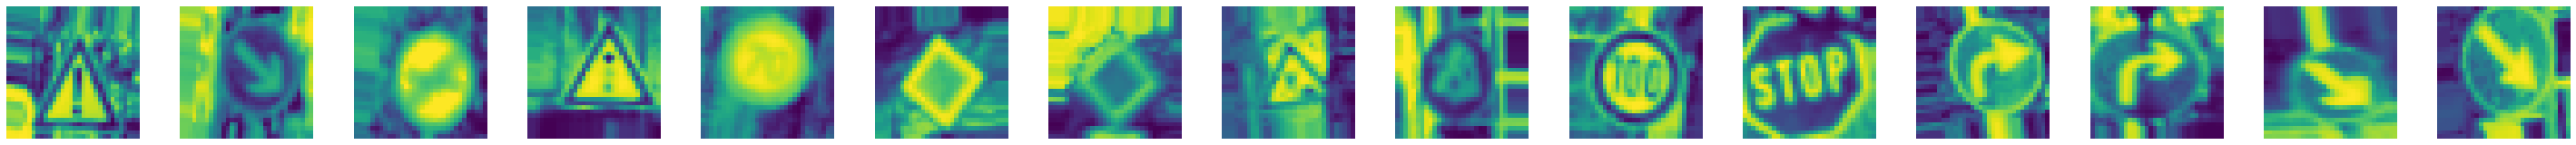

In [28]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(40, 8))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

In [29]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [30]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

## Inception module

In [31]:
input_img = Input(shape = (32, 32, 1))

In [32]:
def conv2d_bn(x, filters, n_row, n_col, strides=(1, 1)):
    x = Conv2D(filters, (n_row ,n_col), padding='same', strides=strides)(x)
    x = BatchNormalization(axis=1, scale=False)(x)
    x = Activation('relu')(x)
    return x

In [33]:
def inception_block(x):
    conv_6_1 = conv2d_bn(x, 64, 3, 1, strides=(1, 1))
    conv_7_1 = conv2d_bn(conv_6_1, 64, 1, 3, strides=(1, 1))
    conv_6_2 = conv2d_bn(x, 64, 1, 7, strides=(1, 1))
    conv_7_2 = conv2d_bn(conv_6_2, 64, 7, 1, strides=(1, 1))
 
    x = concatenate([conv_7_1, conv_7_2], axis=-1)
    return x

In [34]:
# build model
def inception_model():
    x = conv2d_bn(input_img, 32, 3, 3, strides=(1, 1))
    x = conv2d_bn(x, 48, 7, 1, strides=(1, 1))
    x = conv2d_bn(x, 48, 1, 7, strides=(1, 1))
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(rate=0.2)(x)
    x = inception_block(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(rate=0.2)(x)
    x = conv2d_bn(x, 128, 3, 3, strides=(1, 1))
    x = conv2d_bn(x, 256, 3, 3, strides=(1, 1))
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(rate=0.3)(x)
    x = Flatten()(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.4)(x) 
    x = Dense(units=43, activation='softmax')(x)

    return x

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

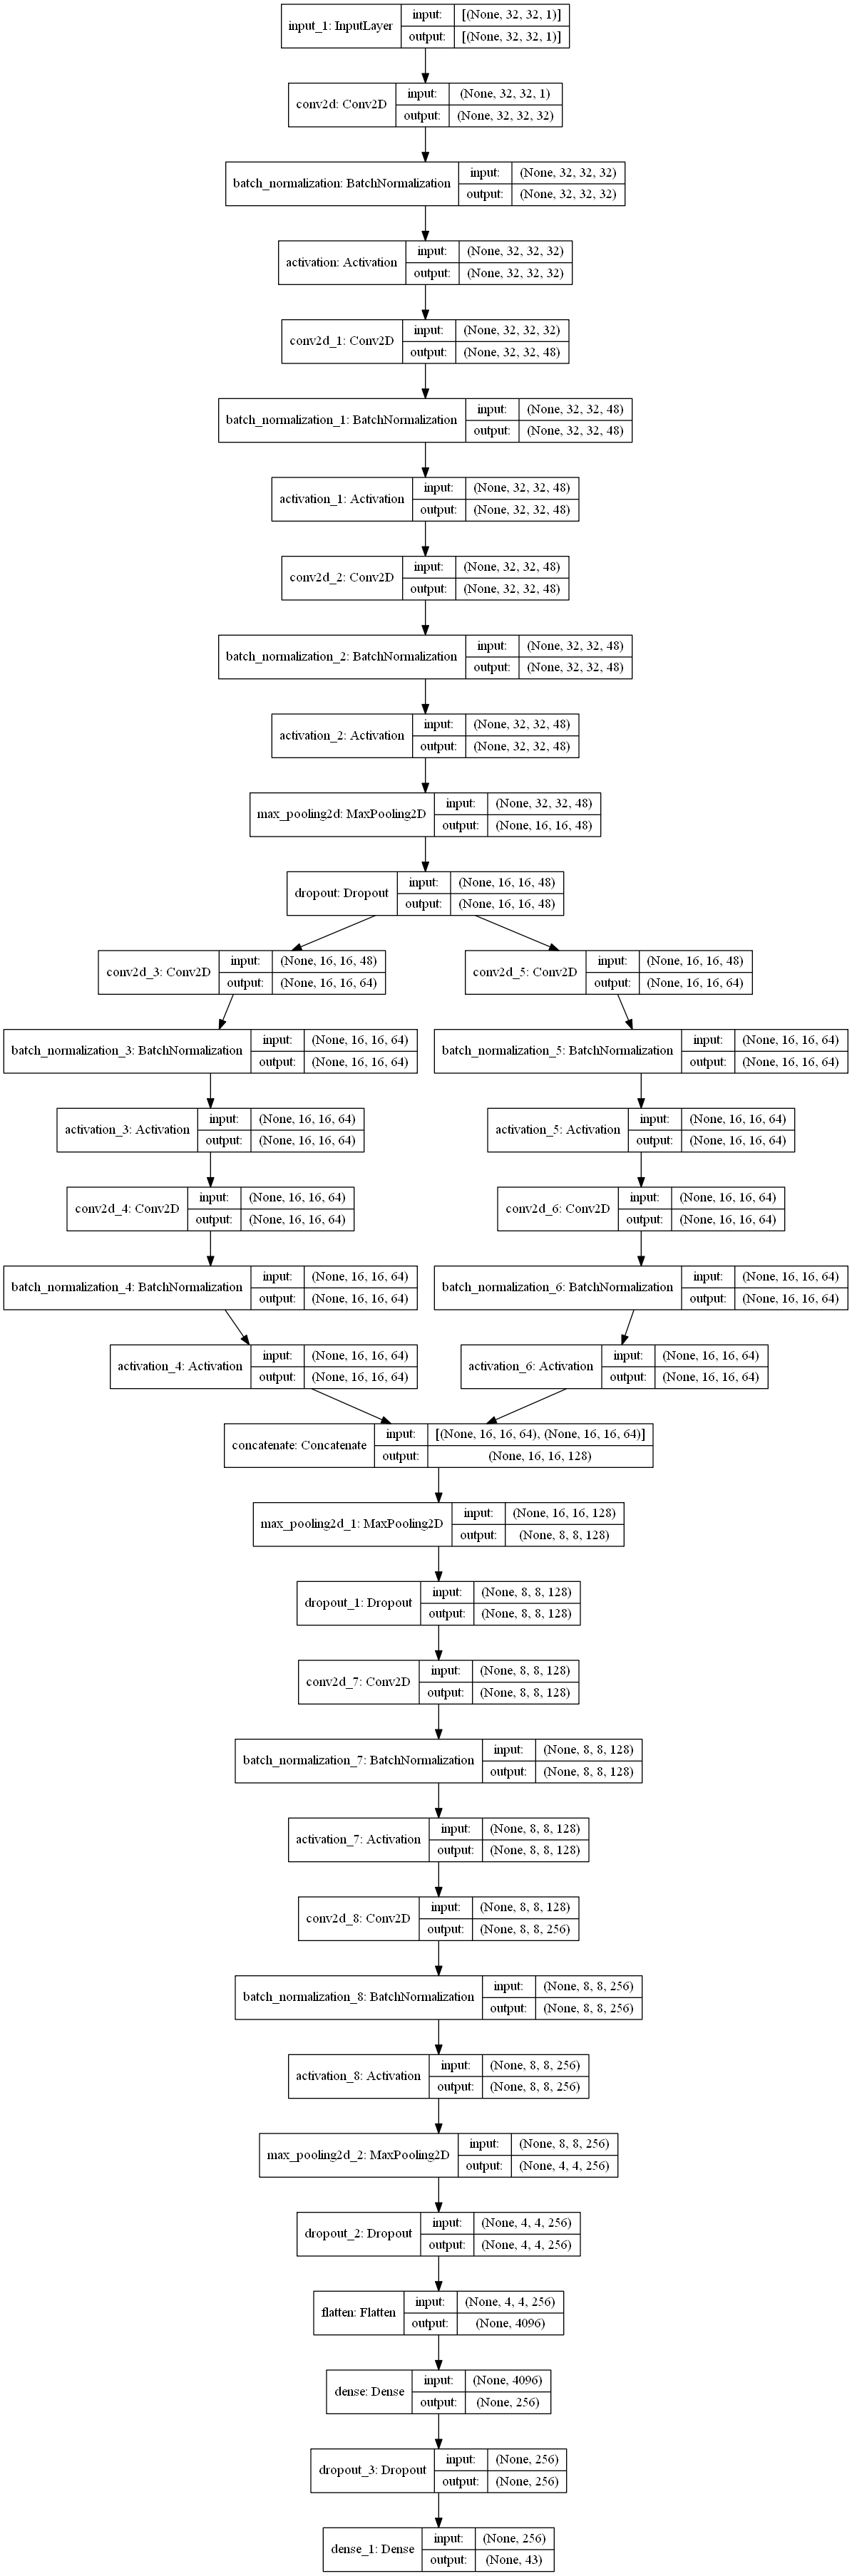

In [35]:
model = Model(inputs = input_img, outputs = inception_model())
print(model.summary())
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [36]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14047745675548953499
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1397558068
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3547812771338449685
physical_device_desc: "device: 0, name: GeForce MX330, pci bus id: 0000:2b:00.0, compute capability: 6.1"
]


In [38]:
import keras
import tensorflow as tf
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 56}) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

## Model Training

In [39]:
batch_size = 16
history = model.fit(datagen.flow(X_train, y_train, batch_size=16), steps_per_epoch=int(len(X_train)/batch_size) , epochs=30, validation_data=(X_val, y_val), shuffle=1)
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16, shuffle=1)

Epoch 1/30
2174/2174 [==============================] - 301s 130ms/step - loss: 3.4531 - accuracy: 0.0836 - val_loss: 2.2972 - val_accuracy: 0.2347
Epoch 2/30
2174/2174 [==============================] - 350s 161ms/step - loss: 2.5832 - accuracy: 0.1871 - val_loss: 1.9275 - val_accuracy: 0.3499
Epoch 3/30
2174/2174 [==============================] - 346s 159ms/step - loss: 2.1654 - accuracy: 0.2974 - val_loss: 1.3210 - val_accuracy: 0.5299
Epoch 4/30
2174/2174 [==============================] - 208s 96ms/step - loss: 1.7039 - accuracy: 0.4345 - val_loss: 0.8952 - val_accuracy: 0.7234
Epoch 5/30
2174/2174 [==============================] - 155s 71ms/step - loss: 1.0239 - accuracy: 0.6510 - val_loss: 0.2392 - val_accuracy: 0.9181
Epoch 6/30
2174/2174 [==============================] - 127s 59ms/step - loss: 0.4931 - accuracy: 0.8342 - val_loss: 0.1736 - val_accuracy: 0.9338
Epoch 7/30
2174/2174 [==============================] - 123s 57ms/step - loss: 0.3056 - accuracy: 0.9012 - val_loss

## Model visualization and validation

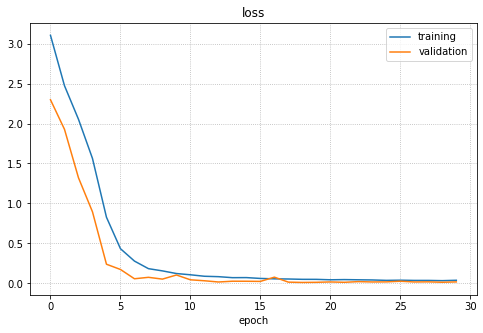

In [47]:
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(8, 5)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.grid(linestyle=':')

fig.savefig(r'D:\Study_3\GTSRB_new\Loss.svg')

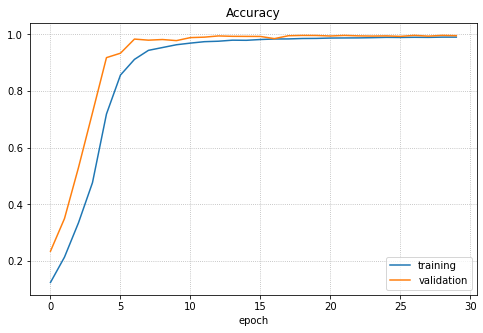

In [48]:
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(8, 5)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.grid(linestyle=':')

fig.savefig(r'D:\Study_3\GTSRB_new\Accuracy.svg')

In [49]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.08438296616077423
Test Accuracy:  0.9806809425354004


## test image

In [ ]:
# https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

# https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

# https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

# https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

# https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg



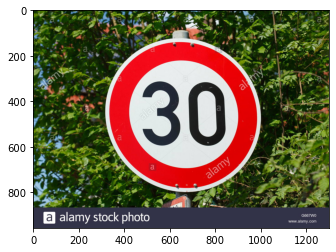

In [106]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


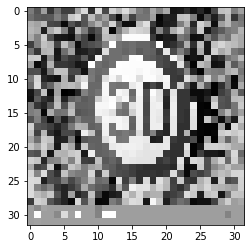

In [107]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [108]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)

In [109]:
#Test image
import numpy as np
print("predicted sign: "+ str(np.argmax(model.predict(img))))

predicted sign: 1


21


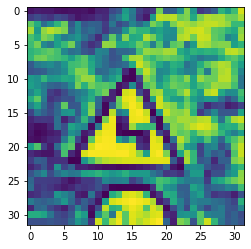

In [62]:
img = X_test[16]
img = img.reshape(1, 32, 32, 1)
plt.imshow(X_test[16])
print(np.argmax(model.predict(img)))

## Save model

In [58]:
# model.save("./training/model_inception.h5")

## Load model

In [18]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [19]:
import os
os.chdir(r'D:\Study_3\GTSRB_new')
from keras.models import load_model
model = load_model('./training/model_inception.h5')

In [20]:
# dictionary of classes...
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Model testing

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def test_on_img(img):
    data = []
    image = cv2.imread(img)
    image = np.asarray(image)
    image = cv2.resize(image, (32,32))
    image = preprocessing(image)
    print(image.shape)
    image = np.array(image)
    data.append(image)
    x_test = np.array(data)
    x_test = x_test.reshape((1, 32, 32, 1))
    y_pred = model.predict(x_test)
    print(x_test.shape)
    return image ,y_pred

#print(y_pred)

(32, 32)
(1, 32, 32, 1)
Predicted traffic sign is :  Ahead only


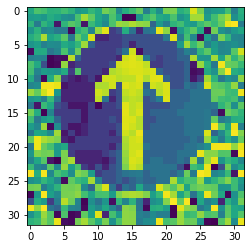

In [22]:
plot, prediction = test_on_img(r'D:\Study_3\AVMLA\kaggle\ahead_new.jpg')
pred = np.argmax(prediction)
if pred in classes:
    print("Predicted traffic sign is : ", classes[pred])
plt.imshow(plot)
plt.show()


(32, 32)
(1, 32, 32, 1)
Predicted traffic sign is :  Speed limit (70km/h)


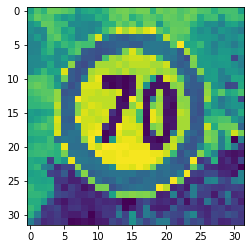

In [23]:
plot, prediction = test_on_img(r'D:\Study_3\AVMLA\kaggle\web_new.png')
pred = np.argmax(prediction)
if pred in classes:
    print("Predicted traffic sign is : ", classes[pred])
plt.imshow(plot)
plt.show()

(32, 32)
(1, 32, 32, 1)
Predicted traffic sign is :  No passing


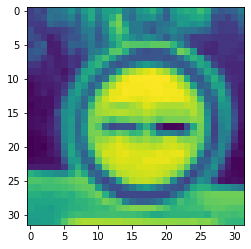

In [37]:
plot, prediction = test_on_img(r'D:\Study_3\GTSRB\Test\00053.png')
pred = np.argmax(prediction)
if pred in classes:
    print("Predicted traffic sign is : ", classes[pred])
plt.imshow(plot)
plt.show()

In [ ]:
# https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

# https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

# https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

# https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

# https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg



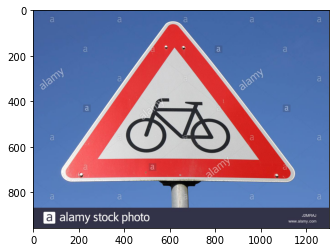

In [42]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


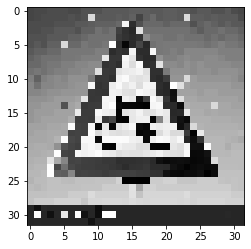

In [43]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [44]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)

In [45]:
#Test image
import numpy as np
print("predicted sign: "+ str(np.argmax(model.predict(img))))
if np.argmax(model.predict(img)) in classes:
    print("Predicted traffic sign is : ", classes[np.argmax(model.predict(img))])

predicted sign: 29
Predicted traffic sign is :  Bicycles crossing


## Confusion matrix evaluation

In [25]:
from sklearn import metrics

In [26]:
print(X_test.shape)

(12630, 32, 32)


In [27]:
y_pred = model.predict(X_test)
y_preds = np.argmax(y_pred,axis=1)

In [29]:
# Printing the confusion matrix
mat = metrics.confusion_matrix(y_test, y_preds)
print(mat)

[[ 60   0   0 ...   0   0   0]
 [  0 716   0 ...   4   0   0]
 [  0   1 749 ...   0   0   0]
 ...
 [  0   1   0 ...  86   0   0]
 [  0   0   0 ...   0  59   0]
 [  0   0   0 ...   0   2  88]]


In [30]:
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      0.99      0.99       720
           2       1.00      1.00      1.00       750
           3       0.97      0.96      0.97       450
           4       1.00      0.98      0.99       660
           5       0.96      0.99      0.97       630
           6       0.99      0.95      0.97       150
           7       0.99      1.00      0.99       450
           8       0.99      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.95      0.97      0.96       420
          12       0.99      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       0.92      1.00      0.96       270
          15       0.99      0.94      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [31]:
import pandas as pd
import seaborn as sn

data = {'y_Actual':    y_test,
        'y_Predicted': y_preds}

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)


In [32]:
FP = mat.sum(axis=1) - np.diag(mat)  
FN = mat.sum(axis=0) - np.diag(mat)
TP = np.diag(mat)
TN = mat.sum() - (FP + FN + TP)

In [33]:
print(TP)
print(FP)
# print(TN)
print(FN)

[ 60 716 749 433 647 621 142 448 438 480 659 406 689 718 269 198 150 337
 369  60  90  74 113 150  82 473 175  60 150  89 138 270  60 210 120 372
 120  60 668  90  86  59  88]
[ 0  4  1 17 13  9  8  2 12  0  1 14  1  2  1 12  0 23 21  0  0 16  7  0
  8  7  5  0  0  1 12  0  0  0  0 18  0  0 22  0  4  1  2]
[ 0  6  2 12  0 25  1  6  4  1  0 21  4  1 23  2  0  0 13  0  0  7  0  4
  2  4  7 12  2  0 17  2  6  6  0  0  1 36  2  6  5  2  2]


In [34]:
print(TP.sum())
print(FP.sum())
# print(TN)
print(FN.sum())

12386
244
244


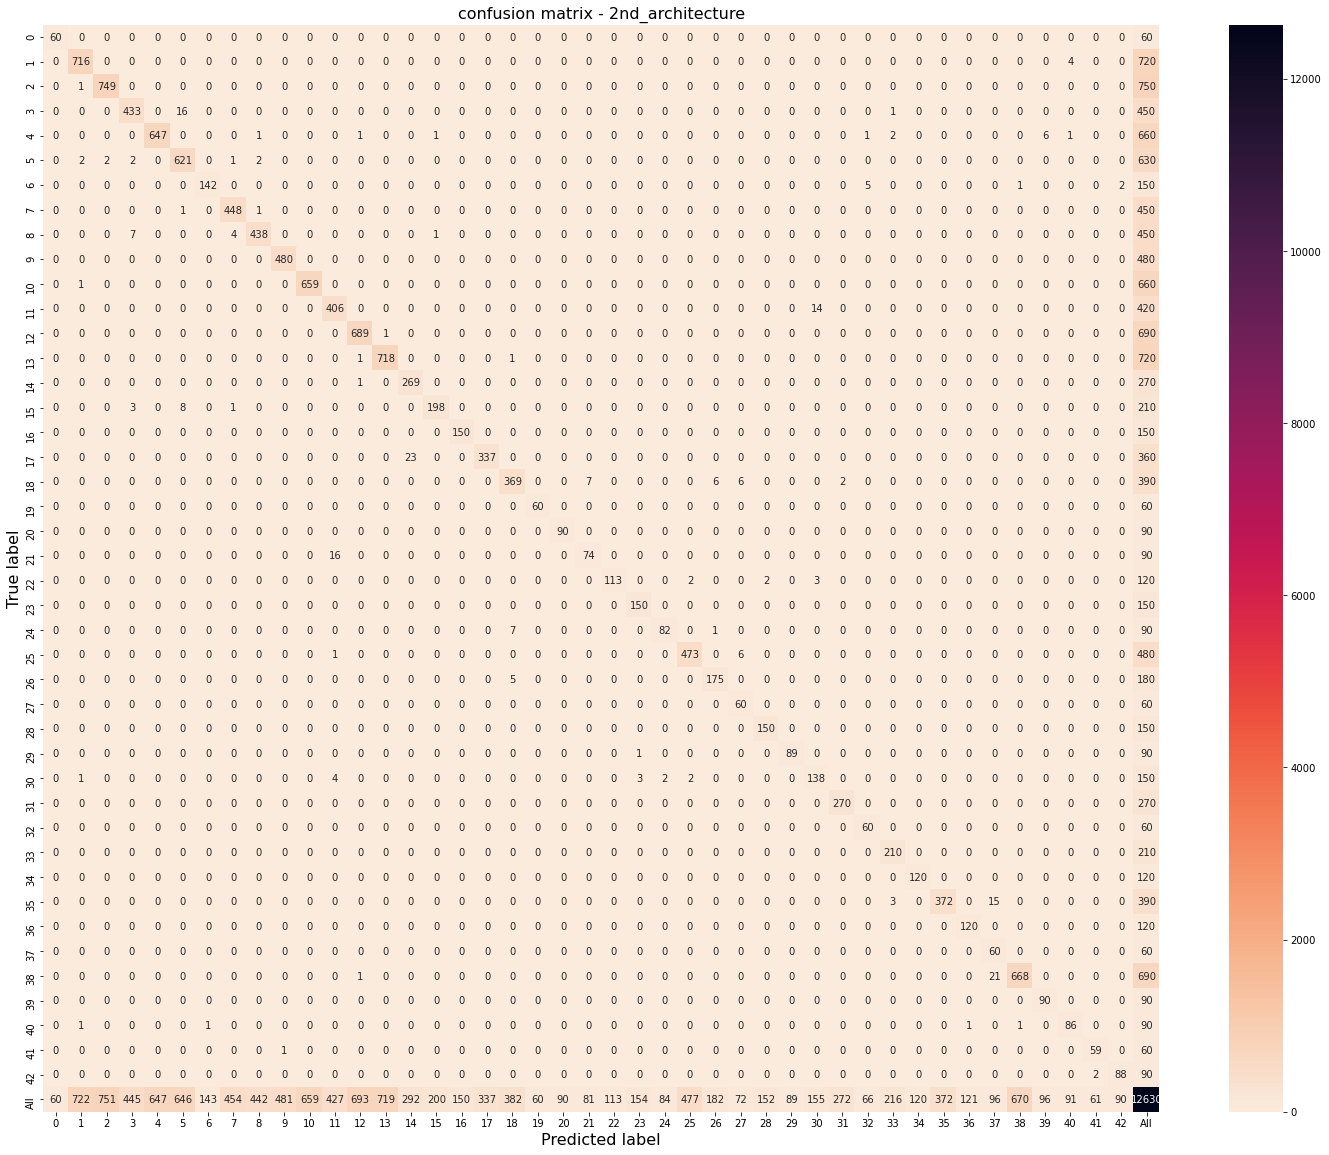

In [35]:
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(25, 20)
sn.heatmap(confusion_matrix, annot=True, fmt = 'd', cmap = 'rocket_r')
plt.ylabel('True label', fontsize=16)  # Axis label
plt.xlabel('Predicted label', fontsize=16)  # Axis label
plt.title('confusion matrix - 2nd_architecture', fontsize=16) 
plt.show()